<h1>Part 4: preliminary modelling</h1>

**Loading necessary libraries and setting display settings**

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, fbeta_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_colwidth', None)

**Loading the data**

In [2]:
df = pd.read_csv("train_final.csv")

**Applying MinMaxScaler** <br>
This results in less iterations needed for the linear model.

In [3]:
minmax = MinMaxScaler()
df2 = pd.DataFrame(minmax.fit_transform(df.drop(columns=["sentiment"])), columns=df.drop(columns="sentiment").columns)
df2 = pd.concat([df2, df[["sentiment"]]], axis=1)

**Splitting the data**

In [4]:
train_df, test_df = train_test_split(df2, test_size=0.3, random_state=2092)

**Feature and target creation**

In [5]:
X_train = train_df.drop(columns=['sentiment'])
y_train = train_df['sentiment']

X_test = test_df.drop(columns=['sentiment'])
y_test = test_df['sentiment']

**Creating baseline model** <br>
For the baseline model we have chosen Logistic Regression. Our primary measure of success is F2, but we also compute AUC ROC and the confusion matrix. We compute all metrics on both the training and testing data.

/home/antoni/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F2 Score (Test): [0.54057541 0.45953757 0.95192581]
F2 Score (Train): [0.64423958 0.49273877 0.96157976]
AUC ROC (Test): 0.9084363906397531
AUC ROC (Train): 0.945577932737845


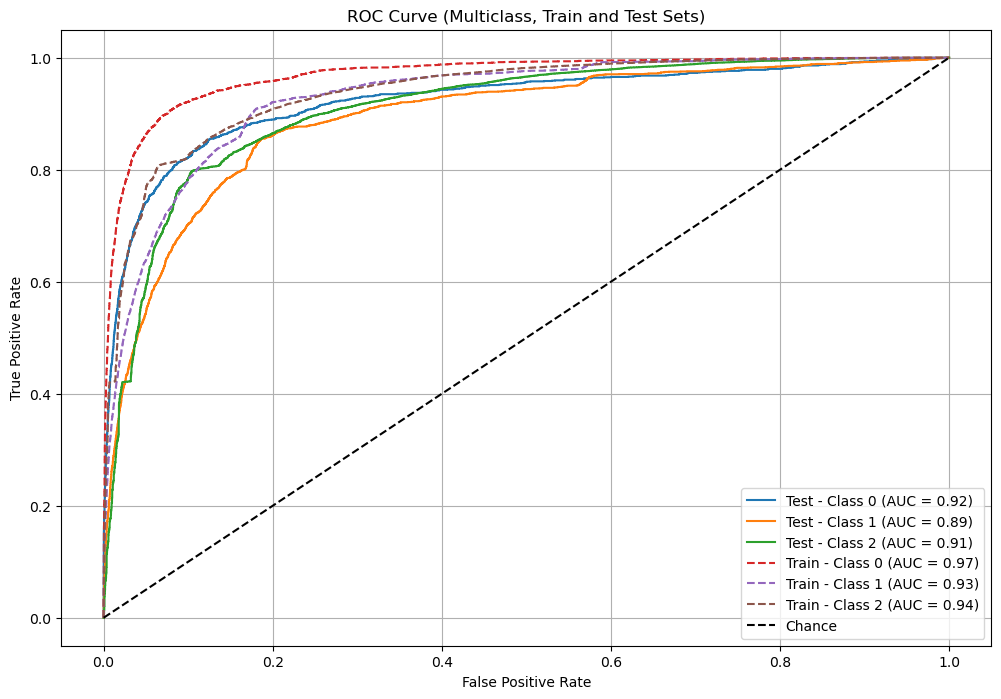

In [6]:
# Fit the model
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Predict class labels and probabilities
y_pred_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)

y_pred_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)

# Calculate F2 score
f2_test = fbeta_score(y_test, y_pred_test, beta=2, average=None)
f2_train = fbeta_score(y_train, y_pred_train, beta=2, average=None)

print(f"F2 Score (Test): {f2_test}")
print(f"F2 Score (Train): {f2_train}")

# Binarize labels for ROC AUC (one-vs-rest)
classes = [0, 1, 2]
y_test_bin = label_binarize(y_test, classes=classes)
y_train_bin = label_binarize(y_train, classes=classes)

# AUC ROC Scores
auc_test = roc_auc_score(y_test_bin, y_prob_test, multi_class='ovo')
auc_train = roc_auc_score(y_train_bin, y_prob_train, multi_class='ovo')

print(f"AUC ROC (Test): {auc_test}")
print(f"AUC ROC (Train): {auc_train}")

# ROC Curve Plot for Test and Train
plt.figure(figsize=(12, 8))

# Plot for Test Set
for i in [0, 1, 2]:
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Test - Class {i} (AUC = {roc_auc:.2f})')

# Plot for Train Set
for i in [0, 1, 2]:
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_prob_train[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='--', label=f'Train - Class {i} (AUC = {roc_auc:.2f})')

# Chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass, Train and Test Sets)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [7]:
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)

print("\n")

cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)

[[  838   136   685]
 [   35  1113  1455]
 [  242   449 19421]]


[[ 2390   226  1310]
 [   79  2789  3263]
 [  376   762 45676]]


**Training various models** <br>
For each we compute F2 and AUC ROC. Again, on both training and testing data.

Training Logistic Regression


/home/antoni/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done


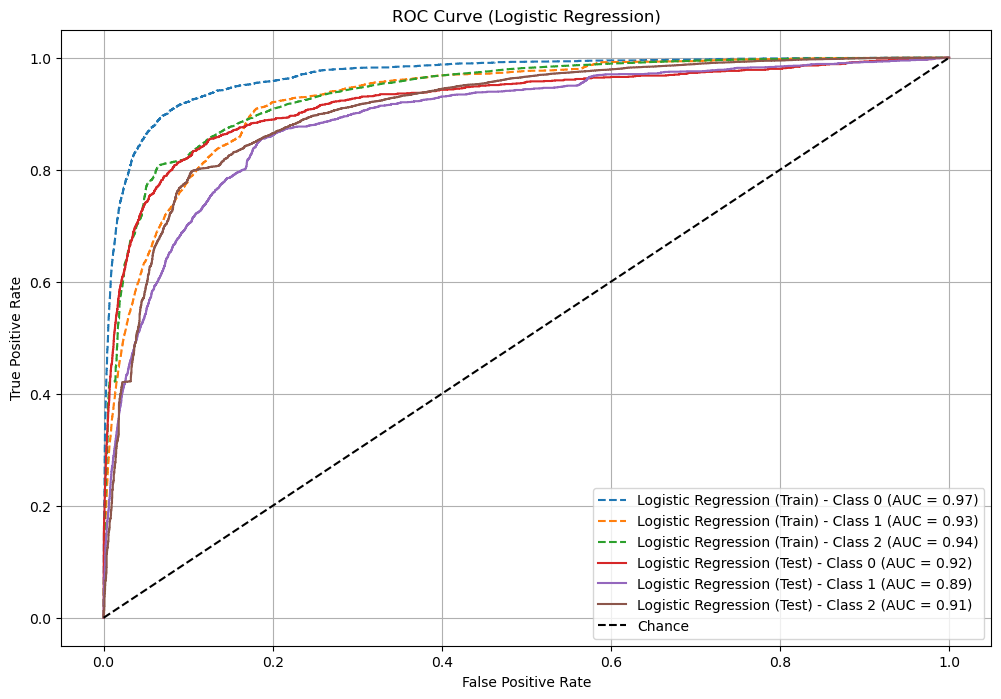

Training Random Forest
Done


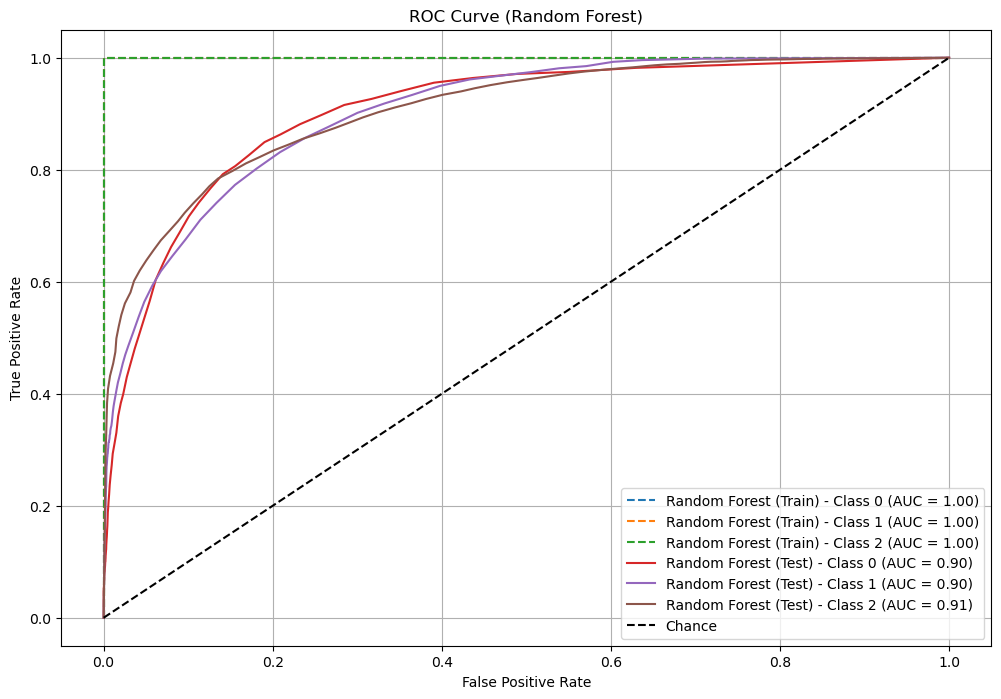

Training Naive Bayes
Done


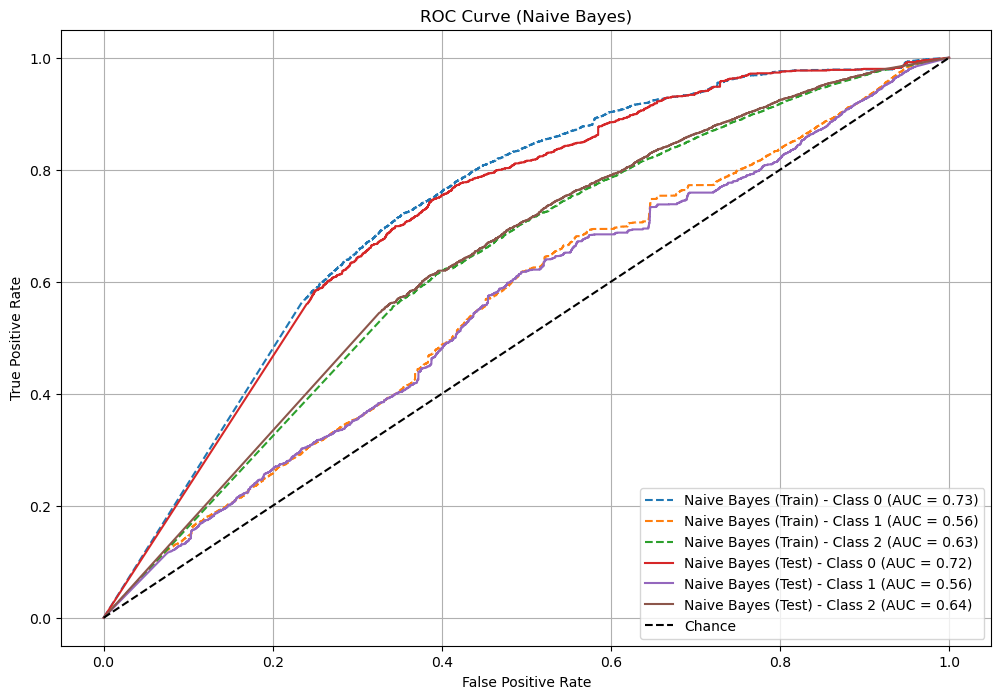

Training Decision Tree
Done


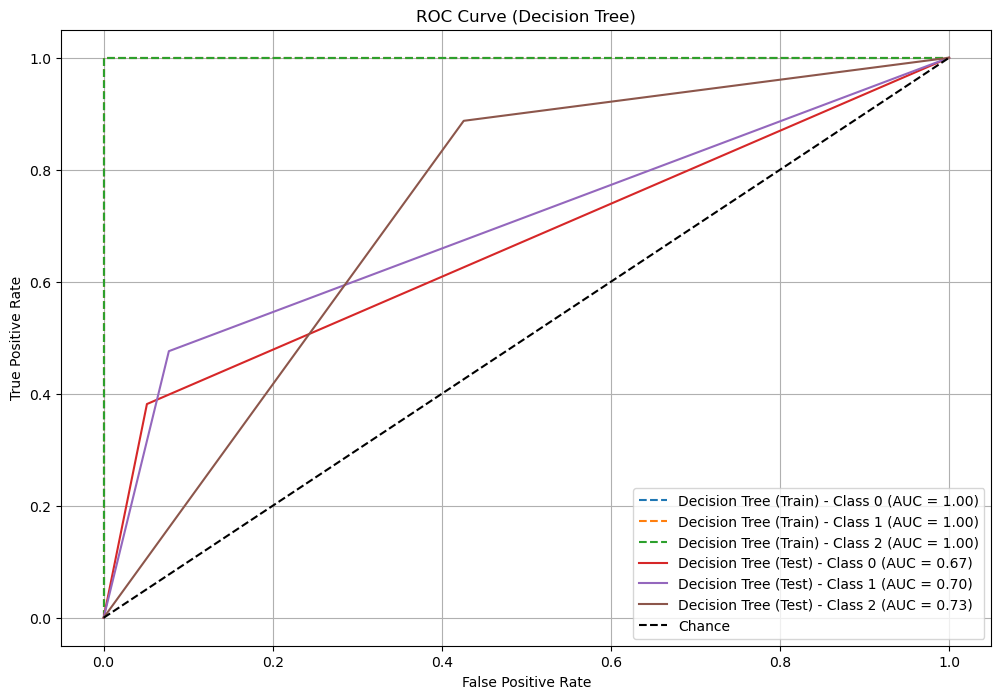

Training XGBoost
Done


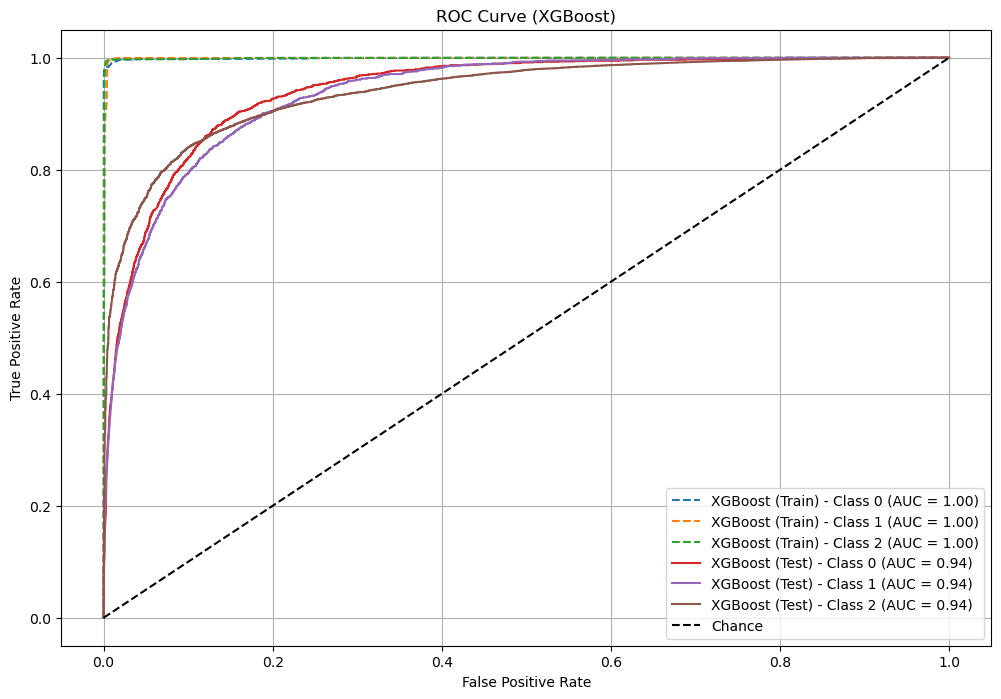

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}
results = []

# Binarize labels for multiclass AUC
classes = [0, 1, 2]
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

results = []

for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, y_train)
    print("Done")

    # Train predictions
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)
    
    # F2 Scores
    f2_train = fbeta_score(y_train, y_train_pred, beta=2, average=None)
    f2_test = fbeta_score(y_test, y_test_pred, beta=2, average=None)
    
    # AUC-ROC Scores (One-vs-Rest)
    auc_train = roc_auc_score(y_train_bin, y_train_proba, multi_class='ovo')
    auc_test = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovo')
    
    # Store metrics
    results.append({
        "Model": name,
        "F2 Score (Train)": f2_train,
        "F2 Score (Test)": f2_test,
        "AUC-ROC (Train)": auc_train,
        "AUC-ROC (Test)": auc_test
    })

    # Plot ROC curves for Train and Test set
    plt.figure(figsize=(12, 8))

    # ROC curve for Train set
    for i in [0, 1, 2]:
        fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_train_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f'{name} (Train) - Class {i} (AUC = {roc_auc:.2f})')

    # ROC curve for Test set
    for i in [0, 1, 2]:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (Test) - Class {i} (AUC = {roc_auc:.2f})')

    # Chance line
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')

    # Labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({name})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Create results DataFrame
results_df = pd.DataFrame(results)

**Displaying the results**

In [10]:
results_df

,Model,F2 Score (Train),F2 Score (Test),AUC-ROC (Train),AUC-ROC (Test)
0,Logistic Regression,"[0.6442395816486064, 0.49273877248153775, 0.9615797562156586]","[0.5405754096245645, 0.4595375722543353, 0.9519258104677039]",0.945578,0.908436
1,Random Forest,"[1.0, 1.0, 1.0]","[0.21622004820643698, 0.37097056762438685, 0.9637721105211748]",1.000000,0.904497
2,Naive Bayes,"[0.37245560848852316, 0.18316906747536013, 0.6381531494517334]","[0.3637542317942808, 0.18068424803991448, 0.6343327266728397]",0.641559,0.638684
3,Decision Tree,"[1.0, 1.0, 1.0]","[0.37540030838571936, 0.4647411852963241, 0.8913284519873338]",1.000000,0.698457
4,XGBoost,"[0.9758783160913653, 0.9804462922662163, 0.9968509925568915]","[0.46598998154495125, 0.5267302113551595, 0.9606335417094669]",0.999065,0.940109


The model which performs best on class 0 is Logistic Regression. The model which performs best on class 1 is XGBoost. Logistic Regression, Random Forest and XGBoost perform similarly well on class 2. Thus, we fill fine-tune Logistic Regression and test ensemble models incorporating Logistic Regression and XGBoost.

**Note:** Logistic Regression does not converge. We will increase the number of iterations in the final model. During testing and exploration we will keep the number capped at 500 due to computational and time limitations.